In [7]:
import random
import gymnasium as gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

SEED = 106

In [8]:
class SARSA:
    """
    SARSA (State-Action-Reward-State-Action) algorithm implementation for reinforcement learning.
    """
    def __init__(self, env, alpha=0.01, gamma=0.9, epsilon=0.9):
        """
        Initialize the SARSA agent.
        
        :param env: The environment to learn from.
        :type env: gym.Env
        :param alpha: The learning rate.
        :type alpha: float
        :param gamma: The discount factor.
        :type gamma: float
        :param epsilon: The exploration rate for the epsilon-greedy policy.
        :type epsilon: float
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_values = self.init_q_values()
        
    def init_q_values(self):
        """
        Initialize the Q-values to zero for all state-action pairs.
        
        :return: A dictionary with state-action pairs as keys and Q-values as values.
        :rtype: dict
        """
        q = {}
        for state in range(self.env.observation_space.n):
            for action in range(self.env.action_space.n):
                q[(state, action)] = 0.0
        return q
    
    def epsilon_greedy(self, state):
        """
        Select an action using the epsilon-greedy policy.
        
        :param state: The current state.
        :type state: int
        :return: The selected action.
        :rtype: int
        """
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return max(
                range(self.env.action_space.n), key=lambda x: self.q_values[(state, x)]
            )
    
    def compute_policy(self, num_of_timesteps, num_of_episodes):
        """
        Learn the policy by running SARSA for a specified number of episodes and timesteps.
        
        :param num_of_timesteps: The number of timesteps in each episode.
        :type num_of_timesteps: int
        :param num_of_episodes: The number of episodes to run.
        :type num_of_episodes: int
        :return: DataFrame containing Q-values for each episode.
        :rtype: pd.DataFrame
        """
        q_values_df = pd.DataFrame()

        for i in range(num_of_episodes):
            # Initialize states
            state, _ = self.env.reset()
            
            # Select the action using epsilon-greedy policy
            action = self.epsilon_greedy(state)
            
            for t in range(num_of_timesteps):
                # Take the action and observe the next state and reward
                next_state, reward, done, _, _ = self.env.step(action)
                
                # Select next action for the next state using epsilon-greedy policy
                next_action = self.epsilon_greedy(next_state)
                
                # Update Q-value
                self.q_values[(state, action)] += self.alpha * (
                    reward + self.gamma * self.q_values[(next_state, next_action)] - self.q_values[(state, action)]
                )
                
                # Move to the next state and action
                state = next_state
                action = next_action
                
                if done:
                    break
            
            # Store Q-values in DataFrame
            q_values_df = pd.concat([q_values_df, pd.DataFrame(self.q_values, index=[i])])
        
        return q_values_df
    
    def execute_policy(self, max_steps=100):
        """
        Execute the learned policy in the environment and visualize the agent's path.
        
        :param max_steps: Maximum number of steps to execute the policy.
        :type max_steps: int
        """
        state = self.env.reset()
        self.env.render()
        total_reward = 0
        
        for _ in range(max_steps):
            action = max(range(self.env.action_space.n), key=lambda x: self.q_values[(state, x)])
            next_state, reward, done, _ = self.env.step(action)
            total_reward += reward
            self.env.render()
            state = next_state
            
            if done:
                break
        
        print(f"Total reward: {total_reward}")
        self.env.close()

In [9]:
# Parameters
alpha = 0.03
gamma = 0.9
epsilon = 0.5
num_of_episodes = 10000
num_of_timesteps = 100

# Initialize the Frozen Lake Environment
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True, render_mode="rgb_array")
env.reset()

# Create SARSA model
model = SARSA(env, alpha=alpha, gamma=gamma, epsilon=epsilon)

# Compute policy and store Q-values
q_values_df = model.compute_policy(num_of_timesteps, num_of_episodes)

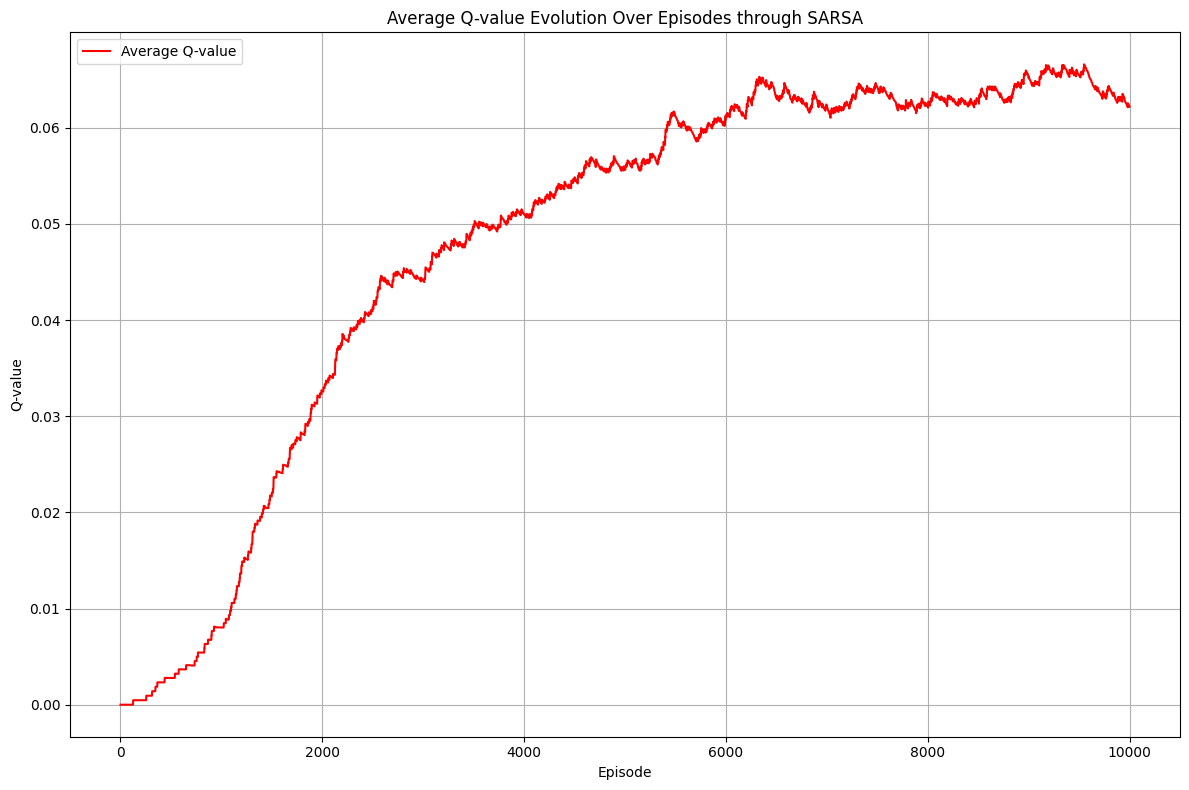

In [10]:
# Calculate average Q-values over episodes
avg_q_values = q_values_df.mean(axis=1)

# Plot the average Q-values
plt.figure(figsize=(12, 8))
plt.plot(avg_q_values.index, avg_q_values.values, label='Average Q-value', color='r')
plt.xlabel('Episode')
plt.ylabel('Q-value')
plt.title('Average Q-value Evolution Over Episodes through SARSA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpretation of Graph

***Overall Convergence Trend:*** By plotting the average Q-value, we can observe the overall convergence trend of the learning process. If the average Q-value stabilizes over time, it indicates that the Q-values are converging, which is a sign that the agent is learning a stable policy.

***Policy Improvement:*** An increasing average Q-value can indicate that the policy is improving, as the agent is learning to choose actions that yield higher rewards. Conversely, a decreasing trend might indicate that the agent is exploring suboptimal actions more frequently.

***Exploration vs. Exploitation:*** The average Q-value can reflect the balance between exploration and exploitation. During initial episodes, the agent explores more (due to higher epsilon), which might lead to lower average Q-values. As the agent exploits more (due to lower epsilon), the average Q-value might increase if the agent is learning a better policy.

***Performance Monitoring:*** Monitoring the average Q-value can help in tuning hyperparameters like learning rate (alpha), discount factor (gamma), and exploration rate (epsilon). If the average Q-value shows erratic behavior or fails to improve, it might indicate a need for hyperparameter adjustments.

In [17]:
# Display the learned policy
policy = np.zeros(env.observation_space.n, dtype=int)
for state in range(env.observation_space.n):
    policy[state] = np.argmax([model.q_values[(state, a)] for a in range(env.action_space.n)])

print("Learned Policy:")
print(policy.reshape((4, 4)))  # Reshape according to FrozenLake's 4x4 grid

Learned Policy:
[[2 3 0 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 1 1 0]]


In [18]:
# Print the learned Q-values
print("Learned Q-values:")
for state in range(env.observation_space.n):
    for action in range(env.action_space.n):
        print(f"Q[{state}, {action}] = {model.q_values[(state, action)]:.2f}")

Learned Q-values:
Q[0, 0] = 0.02
Q[0, 1] = 0.02
Q[0, 2] = 0.02
Q[0, 3] = 0.01
Q[1, 0] = 0.01
Q[1, 1] = 0.01
Q[1, 2] = 0.01
Q[1, 3] = 0.02
Q[2, 0] = 0.03
Q[2, 1] = 0.02
Q[2, 2] = 0.02
Q[2, 3] = 0.02
Q[3, 0] = 0.01
Q[3, 1] = 0.01
Q[3, 2] = 0.01
Q[3, 3] = 0.02
Q[4, 0] = 0.03
Q[4, 1] = 0.02
Q[4, 2] = 0.02
Q[4, 3] = 0.01
Q[5, 0] = 0.00
Q[5, 1] = 0.00
Q[5, 2] = 0.00
Q[5, 3] = 0.00
Q[6, 0] = 0.06
Q[6, 1] = 0.06
Q[6, 2] = 0.05
Q[6, 3] = 0.01
Q[7, 0] = 0.00
Q[7, 1] = 0.00
Q[7, 2] = 0.00
Q[7, 3] = 0.00
Q[8, 0] = 0.02
Q[8, 1] = 0.04
Q[8, 2] = 0.04
Q[8, 3] = 0.05
Q[9, 0] = 0.08
Q[9, 1] = 0.12
Q[9, 2] = 0.10
Q[9, 3] = 0.08
Q[10, 0] = 0.20
Q[10, 1] = 0.15
Q[10, 2] = 0.17
Q[10, 3] = 0.06
Q[11, 0] = 0.00
Q[11, 1] = 0.00
Q[11, 2] = 0.00
Q[11, 3] = 0.00
Q[12, 0] = 0.00
Q[12, 1] = 0.00
Q[12, 2] = 0.00
Q[12, 3] = 0.00
Q[13, 0] = 0.08
Q[13, 1] = 0.19
Q[13, 2] = 0.19
Q[13, 3] = 0.18
Q[14, 0] = 0.25
Q[14, 1] = 0.51
Q[14, 2] = 0.49
Q[14, 3] = 0.48
Q[15, 0] = 0.00
Q[15, 1] = 0.00
Q[15, 2] = 0.00
Q[15, 3] = 0.0

In [19]:
model.execute_policy()

TypeError: unhashable type: 'dict'